In [1]:
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')

In [2]:
raw_data2 = pd.read_excel("C:\\Users\\USER\\Downloads\\KPMG.xlsx")

In [3]:
# Make a copy to use
data = raw_data2.copy()

## 1. Data cleaning

### 1.1. Checking

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           20000 non-null  int64         
 1   product_id               20000 non-null  int64         
 2   customer_id              20000 non-null  int64         
 3   transaction_date         20000 non-null  datetime64[ns]
 4   online_order             19640 non-null  float64       
 5   order_status             20000 non-null  object        
 6   brand                    19803 non-null  object        
 7   product_line             19803 non-null  object        
 8   product_class            19803 non-null  object        
 9   product_size             19803 non-null  object        
 10  list_price               20000 non-null  float64       
 11  standard_cost            19803 non-null  float64       
 12  product_first_sold_date  19803 n

In [5]:
data.head(5)

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0


In [6]:
# Check missing values
data.isna().sum().sort_values(ascending = False)

online_order               360
brand                      197
product_line               197
product_class              197
product_size               197
standard_cost              197
product_first_sold_date    197
transaction_id               0
product_id                   0
customer_id                  0
transaction_date             0
order_status                 0
list_price                   0
dtype: int64

In [7]:
# Check if the transaction_id is unique
data['transaction_id'].is_unique

True

***Comment***
1. There are many missing values but it does not affect the cohort analysis result => temporarily ignore
2. Values in 'transaction_id' column are unique => there are no duplicate records in the dataset
3. We need to filter order_status = ‘Approved’ before cohort analysis

### 1.2. Filtering

In [8]:
# filter order_status = ‘Approved’
df = data.query('order_status == "Approved"')


In [9]:
df = df[['customer_id','transaction_date']]

## 2. Assign the cohort

In [10]:
# Get month-year from transaction_date
df['year_month'] = df['transaction_date'].dt.to_period('M')

In [11]:
df.head(5)

,customer_id,transaction_date,year_month
0,2950,2017-02-25,2017-02
1,3120,2017-05-21,2017-05
2,402,2017-10-16,2017-10
3,3135,2017-08-31,2017-08
4,787,2017-10-01,2017-10


In [12]:
# find start month (Cohort Month) of each customer
df['Cohort Month'] = df.groupby('customer_id').year_month.transform(np.min)

In [13]:
# Caculate Cohort Index
df['Cohort Index'] = df['year_month'].astype(int) - df['Cohort Month'].astype(int) + 1

In [14]:
df.sort_values(['customer_id','Cohort Month','Cohort Index'])

,customer_id,transaction_date,year_month,Cohort Month,Cohort Index
9784,1,2017-01-05,2017-01,2017-01,1
13423,1,2017-02-21,2017-02,2017-01,2
14485,1,2017-03-27,2017-03,2017-01,3
18969,1,2017-03-29,2017-03,2017-01,3
3764,1,2017-04-06,2017-04,2017-01,4
...,...,...,...,...,...
2462,3500,2017-04-25,2017-04,2017-01,4
8561,3500,2017-08-08,2017-08,2017-01,8
16700,5034,2017-01-27,2017-01,2017-01,1
17468,5034,2017-01-03,2017-01,2017-01,1


In [15]:
# Assign the cohort: count distinct customer_id group by 'Cohort Month' and 'Cohort Index'
cohort = df.groupby(['Cohort Month','Cohort Index']).agg(customer_count=('customer_id','nunique')
                                                     ).sort_values(['Cohort Month','Cohort Index']).reset_index()

In [16]:
cohort

,Cohort Month,Cohort Index,customer_count
0,2017-01,1,1347
1,2017-01,2,483
2,2017-01,3,505
3,2017-01,4,499
4,2017-01,5,492
...,...,...,...
73,2017-10,2,6
74,2017-10,3,8
75,2017-11,1,13
76,2017-11,2,5


In [17]:
# pivot cohort table
cohort_pivot = cohort.pivot(index='Cohort Month',
                      columns ='Cohort Index',
                      values = 'customer_count')
cohort_pivot

Cohort Index,1,2,3,4,5,6,7,8,9,10,11,12
Cohort Month,,,,,,,,,,,,
2017-01,1347.0,483.0,505.0,499.0,492.0,475.0,513.0,524.0,489.0,524.0,492.0,510.0
2017-02,800.0,322.0,297.0,311.0,283.0,297.0,306.0,281.0,325.0,306.0,292.0,NaN
2017-03,484.0,167.0,172.0,164.0,180.0,184.0,173.0,209.0,186.0,180.0,NaN,NaN
2017-04,337.0,110.0,121.0,152.0,142.0,118.0,144.0,125.0,129.0,NaN,NaN,NaN
2017-05,213.0,86.0,83.0,88.0,73.0,73.0,74.0,83.0,NaN,NaN,NaN,NaN
2017-06,123.0,45.0,44.0,47.0,45.0,45.0,54.0,NaN,NaN,NaN,NaN,NaN
2017-07,77.0,26.0,26.0,32.0,37.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,51.0,18.0,22.0,18.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,24.0,8.0,7.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Caculate retiontion rate

In [18]:
# Caculate retention rate: cohort dataframe devided by the first column (first month)
first_month = cohort_pivot[cohort_pivot.columns[0]]
retention_rate = cohort_pivot.divide(first_month, axis=0)

In [19]:
retention_rate = retention_rate.round(3)*100

In [20]:
retention_rate

Cohort Index,1,2,3,4,5,6,7,8,9,10,11,12
Cohort Month,,,,,,,,,,,,
2017-01,100.0,35.9,37.5,37.0,36.5,35.3,38.1,38.9,36.3,38.9,36.5,37.9
2017-02,100.0,40.2,37.1,38.9,35.4,37.1,38.2,35.1,40.6,38.2,36.5,NaN
2017-03,100.0,34.5,35.5,33.9,37.2,38.0,35.7,43.2,38.4,37.2,NaN,NaN
2017-04,100.0,32.6,35.9,45.1,42.1,35.0,42.7,37.1,38.3,NaN,NaN,NaN
2017-05,100.0,40.4,39.0,41.3,34.3,34.3,34.7,39.0,NaN,NaN,NaN,NaN
2017-06,100.0,36.6,35.8,38.2,36.6,36.6,43.9,NaN,NaN,NaN,NaN,NaN
2017-07,100.0,33.8,33.8,41.6,48.1,31.2,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,100.0,35.3,43.1,35.3,25.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,100.0,33.3,29.2,37.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4. Visualize with heatmap

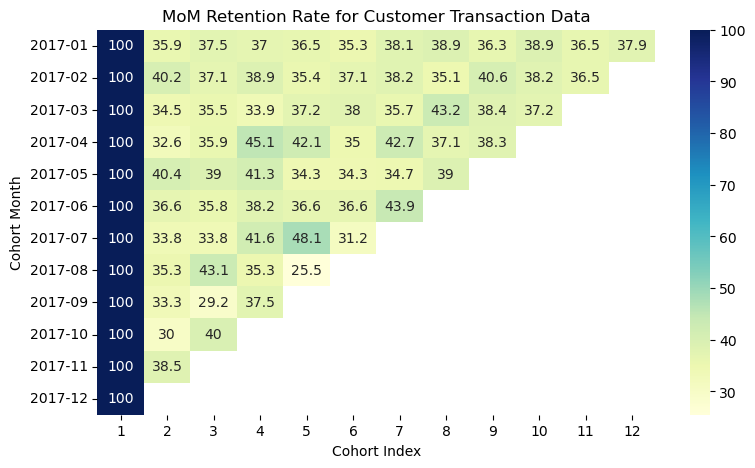

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set heatmap size
plt.figure(figsize = (9,5))

# Create heatmap
sns.heatmap(retention_rate, annot = True, cmap="YlGnBu", fmt='g')
plt.title('MoM Retention Rate for Customer Transaction Data')
plt.yticks(rotation = 'horizontal')

plt.show()

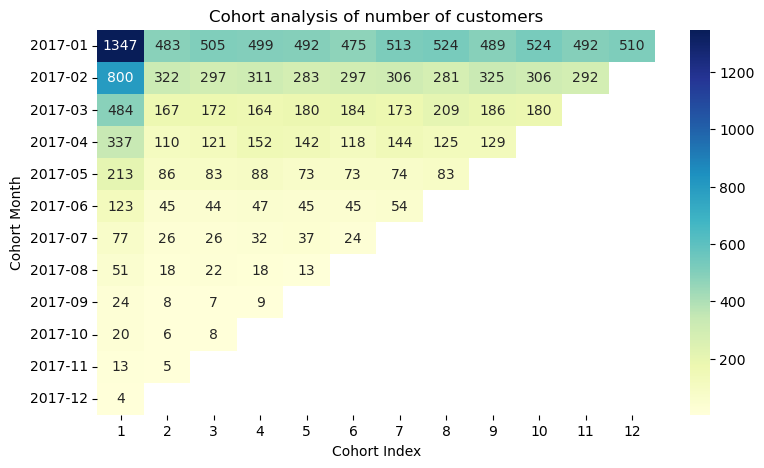

In [23]:
# Set heatmap size
plt.figure(figsize = (9,5))

# Create heatmap
sns.heatmap(cohort_pivot, annot = True, cmap="YlGnBu", fmt='g')
plt.title('Cohort analysis of number of customers')
plt.yticks(rotation = 'horizontal')

plt.show()

## 5. Insights and recommendations

### Insights
- In general, the retention rate at KPMG is quite stable, mostly maintained in the range of 31% to 45%. However, the number of customers who made the first purchase decreased sharply over the months, from 1347 customers (Jan 2017) to 4 customers (Dec 2017)
- Customers who placed their first order between April and July 2017 tend to have higher retention rates than the other groups: 48.1% in the fifth month of July 2017, 45.1% in the fourth month of April 2017.
- Retention rates of customers purchasing their first products in January, February, and March 2017 were relatively stable (about 33% to 43%). Meanwhile, these rates in August, September, and October 2017 are more fluctuating, especially in August: 43.1% in the 3rd month but 25.5% in the 5th month.

### Recommendations
- KPMG did a good job of maintaining stable retention rates over the user's lifetime, but the number of customers who made the first purchase declines over time => We need to gather more information about the context in the past (promotions, seasonal trends, product quality changes, etc.) to analyze the cause and evaluate the effectiveness of marketing campaigns
- The mid-year months (Apr - Jul) have higher retention rates than other groups => focus on finding out the characteristics of these groups to design special offers or new marketing campaigns for other months of the year.